# Finding the minimum of a multimodal function

Level: Intermediate

Topic: Optimization

Can you find the global minimum of this multimodal function? Where in the design space does this occur and what is the corresponding function value? How would you explore this design space?

Please don't look at the function definition and use your math smarts to know where the minimum is. Heck, if you can do that, that's impressive, but that's not really the point of this exercise.

In [62]:
import openmdao.api as om
import numpy as np


prob = om.Problem()

comp = om.ExecComp('obj = 0.1*(x+y) -abs(sin(x) * cos(y) * exp(abs(1 - (x**2 + y**2)**0.5/pi)))')

prob.model.add_subsystem('blackbox', comp, promotes=['*'])

prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'

prob.model.add_design_var('x', lower=-10, upper=10)
prob.model.add_design_var('y', lower=-10, upper=10)
prob.model.add_objective('obj')

prob.setup()

prob.run_driver();


Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.6115904097239777
            Iterations: 7
            Function evaluations: 7
            Gradient evaluations: 7
Optimization Complete
-----------------------------------


## Solution approaches

You have a few different options here. You could:

- Simply plot the design space since this is a 2D function that's relatively cheap.
- Run a global gradient-free optimizer on the function.
- Run a gradient-based optimizer from multiple starting points, keeping track of where the lowest value occurs.

Let's walk through these together and I'll discuss their pros and cons.

## Plot the design space

This is the easiest and most intuitive way to see a design space. But this wouldn't be reasonable in the general case for higher dimensional or expensive models. It also wouldn't necessarily give you the optimum, but you could at least take a look and see how the function looks. Let's do that now using the [DOEDriver from OpenMDAO](http://openmdao.org/twodocs/versions/latest/features/building_blocks/drivers/doe_driver.html).

In [63]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


prob = om.Problem()

prob.model.add_subsystem('blackbox', comp, promotes=['*'])

prob.driver = om.DOEDriver(om.FullFactorialGenerator(levels=41))

prob.model.add_design_var('x', lower=-10, upper=10)
prob.model.add_design_var('y', lower=-10, upper=10)
prob.model.add_objective('obj')
prob.driver.add_recorder(om.SqliteRecorder("cases.sql"))

prob.setup()
prob.run_driver();

/home/john/anaconda3/envs/course/lib/python3.8/site-packages/openmdao/recorders/sqlite_recorder.py:227: UserWarning:The existing case recorder file, cases.sql, is being overwritten.
/home/john/anaconda3/envs/course/lib/python3.8/site-packages/openmdao/visualization/opt_report/opt_report.py:123: DriverWarning:The optimizer report is not applicable for the DOEDriver Driver which does not support optimization


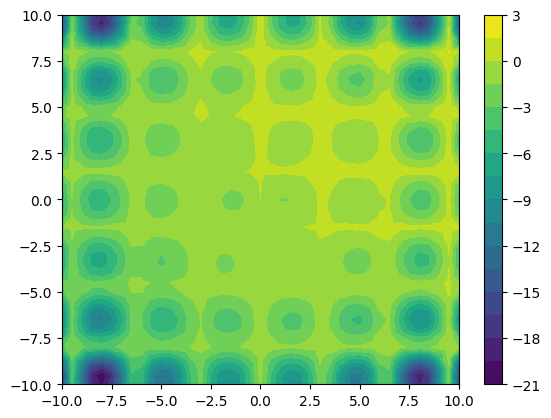

In [64]:
# check recorded cases from each case file
filename = "cases.sql"
cr = om.CaseReader(filename)
cases = cr.list_cases('driver', out_stream=None)

values = []
for case in cases:
    outputs = cr.get_case(case).outputs
    values.append((outputs['x'], outputs['y'], outputs['obj']))
values = np.squeeze(np.array(values))

figure = plt.figure()
contour = plt.tricontourf(values[:, 0], values[:, 1], values[:, 2], levels=21)
plt.colorbar()
plt.show()

Oh wow, that's a pretty rough design space. There are definitely a lot of local minima. But, based on this visualization we can sort of see four main low points near the corners. But which one of those four points is lowest? We probably need to dig deeper into the data, beyond just visualizing it.

In [65]:
sorted_values = values[values[:, 2].argsort(), :]
print(sorted_values[:3, :])

[[ -8.          -9.5        -20.66199056]
 [ -8.         -10.         -19.79686168]
 [  8.          -9.5        -19.06199056]]


All right, it looks like based on the plot data, the lowest point in the function space is -20.66199 at (-8, -9.5). But is that actually the lowest point in this space? Probably not because we had to discretize the space to plot it; we only have access to points on this grid. Let's try some other methods.

## Run a global gradient-free optimizer

We'll now use a [simple genetic algorithm](http://openmdao.org/twodocs/versions/latest/features/building_blocks/drivers/genetic_algorithm.html) from OpenMDAO to optimize this model.

In [66]:
prob = om.Problem()

prob.model.add_subsystem('blackbox', comp, promotes=['*'])

prob.driver = om.SimpleGADriver()
prob.driver.options['bits'] = {'x': 8, 'y': 8}
prob.driver.options['max_gen'] = 5

prob.model.add_design_var('x', lower=-10, upper=10)
prob.model.add_design_var('y', lower=-10, upper=10)
prob.model.add_objective('obj')
prob.driver.add_recorder(om.SqliteRecorder("GA_cases.sql"))

prob.setup()
prob.run_driver();

/home/john/anaconda3/envs/course/lib/python3.8/site-packages/openmdao/recorders/sqlite_recorder.py:227: UserWarning:The existing case recorder file, GA_cases.sql, is being overwritten.


In [67]:
# check recorded cases from each case file
filename = "GA_cases.sql"
cr = om.CaseReader(filename)
cases = cr.list_cases('driver', out_stream=None)

values = []
for case in cases:
    outputs = cr.get_case(case).outputs
    values.append((outputs['x'], outputs['y'], outputs['obj']))
values = np.squeeze(np.array(values))

sorted_values = values[values[:, 2].argsort(), :]
print(sorted_values[0, :])

[ -8.03921569  -9.52941176 -20.78256998]


## Run multiple gradient-based optimizations

In [68]:
prob = om.Problem()

prob.model.add_subsystem('blackbox', comp, promotes=['*'])

prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'

prob.model.add_design_var('x', lower=-10, upper=10)
prob.model.add_design_var('y', lower=-10, upper=10)
prob.model.add_objective('obj')

np.random.seed(1234)
n_samples = 100

values = []
random_starts = np.random.rand(n_samples, 2) * 20 - 10
for (x, y) in random_starts:
    prob.setup()
    prob.set_val('x', x)
    prob.set_val('y', y)
    prob.run_driver();

    values.append((prob['x'], prob['y'], prob['obj']))
values = np.squeeze(np.array(values))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.5163226799777205
            Iterations: 7
            Function evaluations: 9
            Gradient evaluations: 7
Optimization Complete
-----------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.548639620822383
            Iterations: 6
            Function evaluations: 8
            Gradient evaluations: 6
Optimization Complete
-----------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.185370448272815
            Iterations: 6
            Function evaluations: 7
            Gradient evaluations: 6
Optimization Complete
-----------------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.551420299976121
            Iterations: 6
            Function evaluations: 8
            Gradient evaluations:

In [69]:
sorted_values = values[values[:, 2].argsort(), :]
print(sorted_values[:3, :])

[[ -8.06001968  -9.66948136 -20.98095921]
 [  8.0499079   -9.6696239  -19.36996688]
 [  8.04990598  -9.66949297 -19.36996675]]


Cool! We've seen the lowest value yet, occurring at (-8.06002, -9.66948) and yielding -20.98096. Additionally, at least on my computer, this collection of gradient-based optimizations runs the quickest of any of the methods we've tried here. Obviously that's problem-dependent, but it's usually a good idea to start with multiple gradient-based optimizations instead of using a global gradient-free optimizer, just from a computational expense standpoint.

## Recap

I hope this exercise proved to be useful for you to see how to investigate a pretty multimodal and sharp design space. Something like this could crop up in wind turbine layout design, aircraft engine performance optimization, or a slew of other cases. It really pays to systematically explore the design space and better understand it so that you can achieve optimal designs more quickly.